# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.
GPU нам пока не понадобится.

Основные ссылки:
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
https://pytorch.org/docs/stable/nn.html
https://pytorch.org/docs/stable/torchvision/index.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов SubsetRandomSampler и DataLoader.

DataLoader подгружает данные, предоставляемые классом Dataset, во время тренировки и группирует их в батчи. Он дает возможность указать Sampler, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

print("indices is\n", len(val_sampler))

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

indices is
 14651


В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем Flattener.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:

nn_model - собственно, модель с нейросетью

loss - функцию ошибки, в нашем случае CrossEntropyLoss

optimizer - алгоритм оптимизации, в нашем случае просто SGD

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

# Тренируем!

Ниже приведена функция train_model, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию compute_accuracy, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if not scheduler  is None:
            scheduler.step()
            print("step")
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0         
    for i_step, (x, y) in enumerate(val_loader):
        count = i_step
        predictions = nn_model(x)
        pred = torch.argmax(predictions, axis=1)
        correct_samples += torch.sum(pred == y)
        total_samples += y.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    # print("val accuracy is ", val_accuracy)       
    return val_accuracy


    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    raise Exception("Not implemented")
    
    return 0

# val_loader.
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.832622, Train accuracy: 0.407928, Val accuracy: 0.552932
Average loss: 1.456259, Train accuracy: 0.581596, Val accuracy: 0.610812
Average loss: 1.378984, Train accuracy: 0.616319, Val accuracy: 0.635520


# После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [40]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.169266, Train accuracy: 0.215183, Val accuracy: 0.252747
Average loss: 2.007896, Train accuracy: 0.275774, Val accuracy: 0.281073
Average loss: 1.854946, Train accuracy: 0.334130, Val accuracy: 0.370623
Average loss: 1.731816, Train accuracy: 0.406887, Val accuracy: 0.407617
Average loss: 1.682593, Train accuracy: 0.431731, Val accuracy: 0.423521


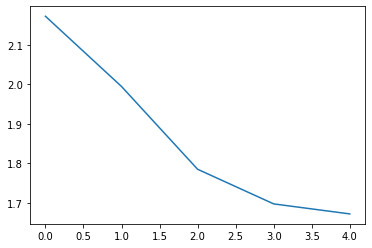

In [37]:
plt.plot(loss_history)
plt.show()


In [7]:

# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.066952, Train accuracy: 0.320650, Val accuracy: 0.440721
Average loss: 1.760358, Train accuracy: 0.484438, Val accuracy: 0.543171
Average loss: 1.623659, Train accuracy: 0.549261, Val accuracy: 0.588970
Average loss: 1.540414, Train accuracy: 0.586954, Val accuracy: 0.598594
Average loss: 1.487758, Train accuracy: 0.605365, Val accuracy: 0.635383


In [7]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma= 2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

step
Average loss: 2.051971, Train accuracy: 0.315531, Val accuracy: 0.443451
step
Average loss: 1.742885, Train accuracy: 0.493107, Val accuracy: 0.546106
step
Average loss: 1.580432, Train accuracy: 0.569327, Val accuracy: 0.611289
step
Average loss: 1.471532, Train accuracy: 0.612907, Val accuracy: 0.621596
step
Average loss: 1.462748, Train accuracy: 0.609050, Val accuracy: 0.584329


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается. Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.
Чтобы это сделать мы приводим код SubsetSampler, который просто проходит по всем заданным индексам последовательно и составляет из них батчи.

Реализуйте функцию evaluate_model, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [8]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    val_sampler = SubsetSampler(indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         sampler=val_sampler)

    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(val_loader):
            pred = model(x)
            pred =  torch.argmax(pred, axis=1)
            predictions.append(pred.detach().numpy()[0])
            ground_truth.append(y.detach().numpy()[0])

    # predictions = np.array(predictions)
    # ground_truth = np.array(ground_truth)
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    print('len pred ', len(predictions))
    print('len indices ', len(indices))
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
print("pred type is ", type(predictions[0]))
print("pred  is ", predictions[0])
print("gt  is ", gt[0])

assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

len pred  14651
len indices  14651
pred type is  <class 'numpy.int64'>
pred  is  4
gt  is  4


# Confusion matrix

Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами i,j - это количество сэмплов класса j, которые модель считает классом i.

image.png

Для того, чтобы облегчить вам задачу, ниже реализована функция visualize_confusion_matrix которая визуализирует такую матрицу.
Вам осталось реализовать функцию build_confusion_matrix, которая ее вычислит.

Результатом должна быть матрица 10x10.

confusion matrix shape is  (10, 10)


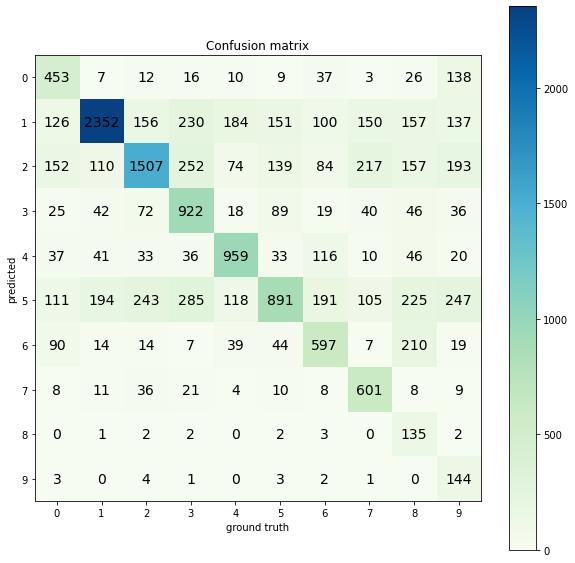

In [9]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), int)
    print("confusion matrix shape is ", confusion_matrix.shape)
    for ind in range(len(ground_truth)):
        i = predictions[ind]
        # print("i shape is ", i.shape)
        j = ground_truth[ind]
        assert(i>=0 and i <10 and j>=0 and j <10)
        confusion_matrix[i][j] += 1

    return confusion_matrix
    
    # TODO: Implement filling the prediction matrix
    # return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

**Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.**

Как и раньше, вам дана функция visualize_images, которой нужно воспрользоваться при реализации функции visualize_predicted_actual. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [10]:
data_train_images = dset.SVHN('./data/', split='train')

data_size = data_train_images.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
train_indices, val_indices = indices[split:], indices[:split]

# val_sampler = SubsetSampler(val_indices)

# val_loader = torch.utils.data.DataLoader(data_train_images, batch_size=1,   
#                                      sampler=val_sampler)

# # imgs = data_train_images[val_indices]
# print("shape is ", data_train_images.data[val_indices].shape)
# print("shape is ", data_train[0][0].size())
predictions, gt = evaluate_model(nn_model, data_train, np.array(val_indices))



len pred  14651
len indices  14651


In [60]:
# imgs = data_train_images
# print(data_train_images.data.shape)
# # print(data_train_images.data[val_indices].shape)

indices size  186


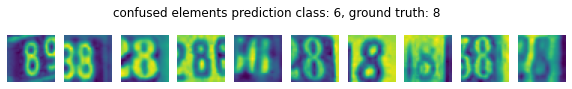

In [11]:
# data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # predicted_samples = predictions[predictions==predicted_class]
    # gt_samples = groud_truth[groud_truth==gt_class]

    # predictions = np.array(predictions)
    # groud_truth = np.array(groud_truth)
    indices = []
    for i in range (len(groud_truth)):
     pred = predictions[i]
     gt = groud_truth[i]
     if (pred==predicted_class and gt == gt_class):
        indices.append(i)
     

    print("indices size ", len(indices))
    # images = data.data[val_indices]
    images = data.data

    visualize_images(indices, images, "confused elements prediction class: %i, ground truth: %i"%(predicted_class, gt_class))

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")


visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
# visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train)

In [59]:
# print("data_train shape ", data_test[0])

a = np.array([4,5,0, 2, 0])
b = np.array([4,9,0, 2])
indices = np.argwhere(a==b).reshape(-1)
# indices = np.squeeze(indices)
print(indices)

# val_sampler = SubsetSampler(indices)
# val_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
#                                          sampler=val_sampler)

[]


/tmp/ipykernel_18435/1880636672.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  indices = np.argwhere(a==b).reshape(-1)


In [34]:
# count = 0
            # _, indices = torch.max(prediction, 1)
            # correct_samples += torch.sum(indices == y)
            # total_samples += y.shape[0]

correct_samples = 0
total_samples = 0         
for i_step, (x, y) in enumerate(val_loader):
    count = i_step
    predictions = nn_model(x)
    pred = torch.argmax(predictions, axis=1)
    correct_samples += torch.sum(pred == y)
    total_samples += y.shape[0]
    # print(y.shape)
    # print(i_step)

val_accuracy = float(correct_samples) / total_samples
print(val_accuracy)
# print(count)
# val_loader.dataset.data
# print(y.shape)
# print(data_train.data.shape)

# all_y = val_loader.dataset.labels
# all_X = val_loader.dataset.data
# # nn_model.eval() # Evaluation mode
# predictions = nn_model(all_X[0])
# print("pred shape ", all_X.shape)



0.6326530612244898
